In [78]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import SVG
from graphviz import Source
from fuzzywuzzy import fuzz
from IPython.display import clear_output
import seaborn as sns
import timeit
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy.stats import mstats
from pandasql import sqldf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import ParameterGrid
from sklearn import tree
from sklearn.tree import export_graphviz
from scipy import stats

# Options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.warnings.filterwarnings('ignore')
%matplotlib inline


In [76]:
column_dtypes = {   'ProductName': 'category',
                    'EngineVersion': 'category',
                    'AppVersion': 'category',
                    'AvSigVersion': 'category',
                    'Platform': 'category',
                    'Processor': 'category',
                    'OsVer': 'category',
                    'OsPlatformSubRelease': 'category',
                    'OsBuildLab': 'category',
                    'SkuEdition': 'category',
                    'PuaMode': 'category',
                    'SmartScreen': 'category',
                    'Census_MDC2FormFactor': 'category',
                    'Census_DeviceFamily': 'category',
                    'Census_ProcessorClass': 'category',
                    'Census_PrimaryDiskTypeName': 'category',
                    'Census_ChassisTypeName': 'category',
                    'Census_PowerPlatformRoleName': 'category',
                    'Census_InternalBatteryType': 'category',
                    'Census_OSVersion': 'category',
                    'Census_OSArchitecture': 'category',
                    'Census_OSBranch': 'category',
                    'Census_OSEdition': 'category',
                    'Census_OSSkuName': 'category',
                    'Census_OSInstallTypeName': 'category',
                    'Census_OSWUAutoUpdateOptionsName': 'category',
                    'Census_GenuineStateName': 'category',
                    'Census_ActivationChannel': 'category',
                    'Census_FlightRing': 'category',
                    'DefaultBrowsersIdentifier': 'category',
                    'AVProductStatesIdentifier': 'category',
                    'CountryIdentifier': 'category',
                    'CityIdentifier': 'category',
                    'OrganizationIdentifier': 'category',
                    'GeoNameIdentifier': 'category',
                    'LocaleEnglishNameIdentifier': 'category',
                    'IeVerIdentifier': 'category',
                    'Census_OEMNameIdentifier': 'category',
                    'Census_OEMModelIdentifier': 'category',
                    'Census_ProcessorManufacturerIdentifier': 'category',
                    'Census_ProcessorModelIdentifier': 'category',
                    'Census_OSInstallLanguageIdentifier': 'category',
                    'Census_OSUILocaleIdentifier': 'category',
                    'Census_FirmwareManufacturerIdentifier': 'category',
                    'Census_FirmwareVersionIdentifier': 'category',
                    'Wdft_RegionIdentifier': 'category'
                }

# Read in training set
print("Read in training set")
df = pd.read_csv("data/train.csv",dtype=column_dtypes, nrows=1000000) # train.csv for full dataset

# Get int and floats
print("Get int and floats")
converted_int = df.select_dtypes(include=['int'])
converted_float = df.select_dtypes(include=['float'])

# Downcast ints and floats
print("Downcast ints and floats")
df[converted_int.columns] = converted_int.apply(pd.to_numeric,downcast='signed')
df[converted_float.columns] = converted_float.apply(pd.to_numeric,downcast='float')


Read in training set
Get int and floats
Downcast ints and floats


# Reusable Code

In [6]:
def my_score_function(pipe):
    # Fit
    pipe.fit(train_X, train_y)
    # decision function
    y_scores = pipe.decision_function(dev_X)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(dev_y, y_scores)

    # Plot ROC Curve
    def plot_roc_curve(fpr, tpr, label=None):
        plt.plot(fpr, tpr, linewidth=2, label=label)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.axis([0, 1, 0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
    plot_roc_curve(fpr, tpr)
    plt.show()
    # Print ROC AUC Score
    print("AUC = ", roc_auc_score(dev_y, y_scores))

In [7]:
simple_clf = linear_model.RidgeClassifier(alpha=1.0)


In [91]:
simple_tree_clf = tree.DecisionTreeClassifier(max_depth=3)


In [9]:
def try_param_grid(pipe, param_grid):
    best_score = 0
    for g in ParameterGrid(param_grid):
        pipe.set_params(**g)    
        print("Fitting")    
        pipe.fit(train_X, train_y)    
        y_scores = pipe.decision_function(dev_X)
        auc = roc_auc_score(dev_y, y_scores)
        if auc > best_score:
            best_score = auc
            best_grid = g

    print ("AUC" , best_score)
    print ("Grid:", best_grid)
    return best_score, best_grid


# Datasets

In [10]:
# Ordered split
_80_percent = int(df.shape[0] * .80)
train, dev = df.iloc[0:_80_percent], df.iloc[_80_percent:]

# Print Shape
train.shape, dev.shape

((800000, 83), (200000, 83))

In [11]:
train_X = train.drop(["HasDetections"], axis=1).values
train_y = train[['HasDetections']].values
dev_X = dev.drop(["HasDetections"], axis=1).values
dev_y = dev[['HasDetections']].values
print(train_X.shape, train_y.shape, dev_X.shape, dev_y.shape)

(800000, 82) (800000, 1) (200000, 82) (200000, 1)


In [12]:
def print_indices():
    i = 0
    for column in df.columns:
        print(i, "{}Idx".format(column))
        i = i + 1
print_indices()

0 MachineIdentifierIdx
1 ProductNameIdx
2 EngineVersionIdx
3 AppVersionIdx
4 AvSigVersionIdx
5 IsBetaIdx
6 RtpStateBitfieldIdx
7 IsSxsPassiveModeIdx
8 DefaultBrowsersIdentifierIdx
9 AVProductStatesIdentifierIdx
10 AVProductsInstalledIdx
11 AVProductsEnabledIdx
12 HasTpmIdx
13 CountryIdentifierIdx
14 CityIdentifierIdx
15 OrganizationIdentifierIdx
16 GeoNameIdentifierIdx
17 LocaleEnglishNameIdentifierIdx
18 PlatformIdx
19 ProcessorIdx
20 OsVerIdx
21 OsBuildIdx
22 OsSuiteIdx
23 OsPlatformSubReleaseIdx
24 OsBuildLabIdx
25 SkuEditionIdx
26 IsProtectedIdx
27 AutoSampleOptInIdx
28 PuaModeIdx
29 SModeIdx
30 IeVerIdentifierIdx
31 SmartScreenIdx
32 FirewallIdx
33 UacLuaenableIdx
34 Census_MDC2FormFactorIdx
35 Census_DeviceFamilyIdx
36 Census_OEMNameIdentifierIdx
37 Census_OEMModelIdentifierIdx
38 Census_ProcessorCoreCountIdx
39 Census_ProcessorManufacturerIdentifierIdx
40 Census_ProcessorModelIdentifierIdx
41 Census_ProcessorClassIdx
42 Census_PrimaryDiskTotalCapacityIdx
43 Census_PrimaryDiskTyp

# Model 1 - AV Products Installed

In [9]:
AVProductsInstalledIdx = 10

class GetAndImputeAVProductsInstalled(BaseEstimator, TransformerMixin):
    def __init__(self, uses_impute_average=True):
        self.uses_impute_average = uses_impute_average
        self.impute_value = None
        
    def fit(self, X, y=None):
        value = X[:, AVProductsInstalledIdx].astype(float)
        if self.uses_impute_average:
            self.impute_value = np.nanmean(value)
        else:
            self.impute_value = 2.0
        return self
    
    def transform(self, X, y=None):
        value = X[:, AVProductsInstalledIdx].astype(float)
        value[np.isnan(value)] = self.impute_value
        return np.c_[value]


AUC 0.5693117661532048
Grid: {'get_and_impute_av_products_installed__uses_impute_average': False}


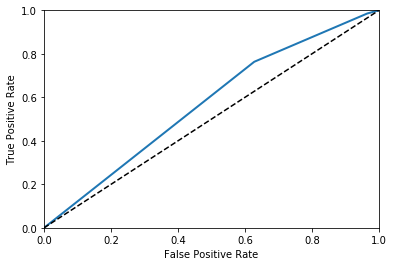

AUC =  0.5693117661532048


In [63]:
# Pipeline
pipe = Pipeline([
    ('get_and_impute_av_products_installed', GetAndImputeAVProductsInstalled()),
    ('clf', simple_clf)
])

# # Parameters
param_grid = [{'get_and_impute_av_products_installed__uses_impute_average': [True, False]}]
best_score, best_grid = try_param_grid(pipe, param_grid)

pipe.set_params(**best_grid)
my_score_function(pipe)

# Model 2 - Monitor Size

In [93]:
Census_InternalPrimaryDiagonalDisplaySizeInInchesIdx = 48

class GetDiagonalMonitorFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, impute_method="mean", 
                 add_is_tiny_monitor_feature=True,
                 add_is_large_monitor_feature=True,
                 drop_original_feature=False                 
                ):
        # impute is mean, median, or 13.9
        self.impute_method = impute_method
        self.add_is_tiny_monitor_feature = add_is_tiny_monitor_feature
        self.add_is_large_monitor_feature = add_is_large_monitor_feature
        self.drop_original_feature = drop_original_feature
        self.impute_value = None
        
    def fit(self, X, y=None):
        value = X[:, Census_InternalPrimaryDiagonalDisplaySizeInInchesIdx].astype(float)
        if self.impute_method == "mean":
            self.impute_value = np.nanmean(value)
        elif self.impute_method == "median":
            self.impute_value = np.nanmedian(value)
        else:
            self.impute_value = 13.9
        return self
    
    def transform(self, X, y=None):           
        # Impute
        value = X[:, AVProductsInstalledIdx].astype(float)
        value[np.isnan(value)] = self.impute_value
        
        # Output variable
        output = np.c_[value]
        
        # Tiny monitor
        if self.add_is_tiny_monitor_feature:
            is_tiny_monitor = value <= 13.2            
            output = np.c_[output, is_tiny_monitor]
        
        # Large monitor
        if self.add_is_large_monitor_feature:
            is_large_monitor = value > 18.7
            output = np.c_[output, is_large_monitor]
                            
        # Drop original feature (Don't allow it to be dropped if only feature)
        if self.drop_original_feature and output.shape[1] > 1:
            return output[:, 1:]
        else:
            return output        


Fitting {'get_diagonal_monitor_features__add_is_large_monitor_feature': True, 'get_diagonal_monitor_features__add_is_tiny_monitor_feature': True, 'get_diagonal_monitor_features__drop_original_feature': True, 'get_diagonal_monitor_features__impute_method': 'mean'}
Fitting {'get_diagonal_monitor_features__add_is_large_monitor_feature': True, 'get_diagonal_monitor_features__add_is_tiny_monitor_feature': True, 'get_diagonal_monitor_features__drop_original_feature': True, 'get_diagonal_monitor_features__impute_method': 'median'}
Fitting {'get_diagonal_monitor_features__add_is_large_monitor_feature': True, 'get_diagonal_monitor_features__add_is_tiny_monitor_feature': True, 'get_diagonal_monitor_features__drop_original_feature': True, 'get_diagonal_monitor_features__impute_method': '13.9'}
Fitting {'get_diagonal_monitor_features__add_is_large_monitor_feature': True, 'get_diagonal_monitor_features__add_is_tiny_monitor_feature': True, 'get_diagonal_monitor_features__drop_original_feature': Fals

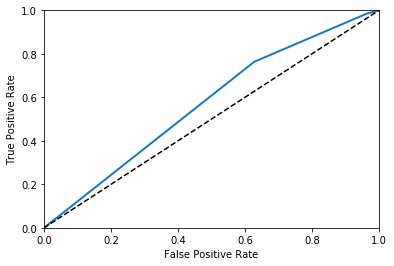

AUC =  0.5693486271527028


In [143]:
# Pipeline
pipe = Pipeline([
    ('get_diagonal_monitor_features', GetDiagonalMonitorFeatures()),
    ('clf', simple_clf)
])

# # Parameters
param_grid = [{'get_diagonal_monitor_features__impute_method': ["mean", "median", "13.9"],
              'get_diagonal_monitor_features__add_is_tiny_monitor_feature': [True, False],
               'get_diagonal_monitor_features__add_is_large_monitor_feature': [True, False],
               'get_diagonal_monitor_features__drop_original_feature': [True, False]
              }]
best_score, best_grid = try_param_grid(pipe, param_grid)

pipe.set_params(**best_grid)
my_score_function(pipe)

# Model 3 - Combining

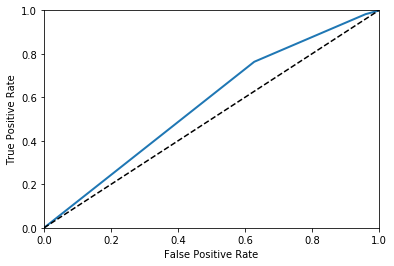

AUC =  0.5693138476548648


In [98]:
pipe1 = Pipeline([
    ('get_and_impute_av_products_installed', GetAndImputeAVProductsInstalled())
])
g = {'get_and_impute_av_products_installed__uses_impute_average': False}
pipe1.set_params(**g)

pipe2 = Pipeline([
    ('get_diagonal_monitor_features', GetDiagonalMonitorFeatures())
])
g = {'get_diagonal_monitor_features__add_is_large_monitor_feature': False, 'get_diagonal_monitor_features__add_is_tiny_monitor_feature': False, 'get_diagonal_monitor_features__drop_original_feature': False, 'get_diagonal_monitor_features__impute_method': 'mean'}
pipe2.set_params(**g)


union = FeatureUnion([#("pipe_one", pipe1)
                      ("pipe_two", pipe2)
                     ])

pipe = Pipeline([
    ('union', union),
    ('scale', StandardScaler()),
    ('clf', simple_clf)  
])

my_score_function(pipe)
    

Learned that the first two variables are highly correlated (one way is from a scatter plot), and diagonal monitor has slightly better results when it is reduced to one variable, and has a bit of improvement with the boolean features.  Deciding to drop the monitor size anyway because the AVProductsInstalled makes more sense as a feature going forward into the test set.

# Model 4 - Is Gamer

In [100]:
Wdft_IsGamerIdx = 80

class GetIsGamerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_if_null_feature=False             
                ):
        # impute is mean, median, or 13.9
        self.add_if_null_feature = add_if_null_feature
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):           
        value = X[:, Wdft_IsGamerIdx].astype(float)                
        
        is_gamer = value == 1
        
        # If Null Feature
        if self.add_if_null_feature:
            is_gamer_is_null = np.isnan(value)
            return np.c_[is_gamer, is_gamer_is_null]
        else:
            return np.c_[is_gamer]                                 


Fitting
AUC 0.5230293900576614
Grid: {'get_is_gamer_features__add_if_null_feature': False}


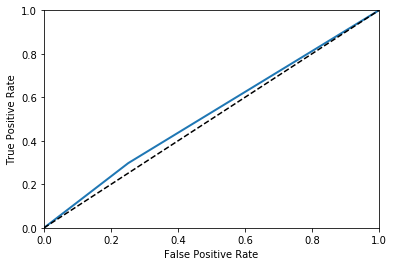

AUC =  0.5230293900576614


In [104]:
# Pipeline
pipe = Pipeline([
    ('get_is_gamer_features', GetIsGamerFeatures()),
    ('clf', simple_clf)
])

# # Parameters
param_grid = [{'get_is_gamer_features__add_if_null_feature': [True, False]
              }]
best_score, best_grid = try_param_grid(pipe, param_grid)

pipe.set_params(**best_grid)
my_score_function(pipe)

It is a difference between .5230 and .5248 (0.0018) to include the null feature.  I will not include it for now, but come back for it later if experimenting

# Model 5 - Combining

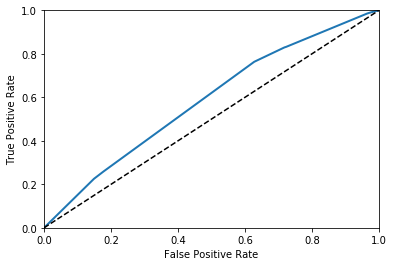

AUC =  0.5846013754165562


In [110]:
pipe1 = Pipeline([
    ('get_and_impute_av_products_installed', GetAndImputeAVProductsInstalled())
])
g = {'get_and_impute_av_products_installed__uses_impute_average': False}
pipe1.set_params(**g)

pipe2 = Pipeline([
    ('get_is_gamer_features', GetIsGamerFeatures())
])
g = {'get_is_gamer_features__add_if_null_feature': False}
pipe2.set_params(**g)


union = FeatureUnion([("pipe_one", pipe1),
                      ("pipe_two", pipe2)
                     ])

pipe = Pipeline([
    ('union', union),
    ('scale', StandardScaler()),
    ('clf', simple_clf)  
])

my_score_function(pipe)
    

AUC = .5843, an improvement of 0.015 over the original 0.5693

I will hold out and not include is_gamer into the model yet, perhaps later on when looking to increase the score a bit more.  I don't want to complicate things until it truely seems worth it to add it.

The true positive grew a bit closer, it seems gamer computers are a bit more likely to have viruses.

# Model 6

In [89]:
df.select_dtypes(include=['category']).describe()

,ProductName,EngineVersion,AppVersion,AvSigVersion,DefaultBrowsersIdentifier,AVProductStatesIdentifier,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,PuaMode,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Wdft_RegionIdentifier
count,1000000,1000000,1000000,1000000,48303,995907,1000000,963487,691064,999981,1000000,1000000,1000000,1000000,1000000,999997,1000000,262,993347,644223,1000000,1000000,989473,988687,995367,995362,4125,998544,999939,999994,290170,1000000,1000000,1000000,1000000,1000000,1000000,993300,1000000,1000000,1000000,1000000,1000000,979547,982112,965907
unique,6,60,95,7353,784,8192,222,50872,46,272,247,4,3,22,9,509,8,1,209,13,12,3,2003,59913,4,2513,3,4,38,10,36,333,3,20,25,24,9,39,104,6,4,6,7,382,29161,15
top,win8defender,1.1.15200.1,4.18.1807.18075,1.273.1420.0,239,53447,43,130775,27,277,75,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,on,137,RequireAdmin,Notebook,Windows.Desktop,2668,313586,5,2697,mid,HDD,Notebook,Mobile,lion,10.0.17134.228,amd64,rs4_release,Core,CORE,UUPUpgrade,8,31,FullAuto,IS_GENUINE,Retail,Retail,142,33105,10
freq,989320,431547,577163,11576,5141,652936,44762,10702,470461,172045,234658,966030,908729,967607,438464,409799,618374,262,435085,483829,641426,998368,144664,34045,878040,32433,2345,650454,588678,693282,227752,158286,908763,448847,389526,389515,292561,356262,355316,442555,883396,528589,936945,302718,10035,201587


In [49]:
DefaultBrowsersIdentifierIdx = 8

class GetDefaultBrowsersIdentifierFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):        
        value = X[:, DefaultBrowsersIdentifierIdx]
        value = ["missing" if x is np.nan else x for x in value]
        return np.c_[value]


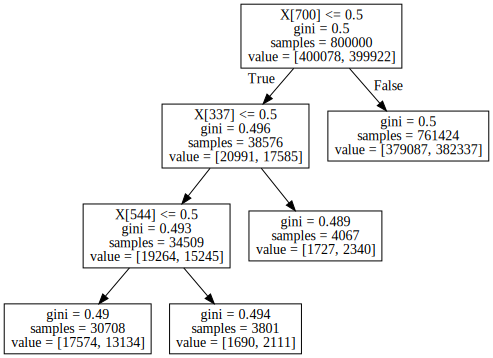

In [92]:
tree_train_X = GetDefaultBrowsersIdentifierFeatures().fit_transform(train_X)
tree_train_X = OneHotEncoder().fit_transform(tree_train_X)
simple_tree_clf.fit(tree_train_X, train_y)
graph = tree.export_graphviz(simple_tree_clf, out_file=None)  
Source(graph)


In [79]:
# Pipeline
pipe = Pipeline([
    ('get_default_browsersIdentifier_features', GetDefaultBrowsersIdentifierFeatures()),
    ('categorical_encoder', OneHotEncoder())
    ('clf', simple_tree_clf)
])

pipe.fit(train_X, train_y)


TypeError: 'tuple' object is not callable

# Model 7

In [93]:
AVProductStatesIdentifierIdx = 9

class GetAVProductStatesIdentifierFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):        
        value = X[:, AVProductStatesIdentifierIdx]
        value = ["missing" if x is np.nan else x for x in value]
        return np.c_[value]


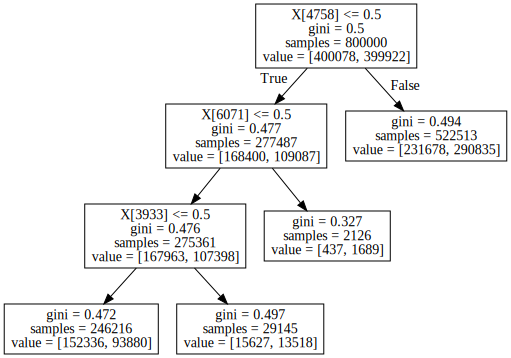

In [94]:
tree_train_X = GetAVProductStatesIdentifierFeatures().fit_transform(train_X)
tree_train_X = OneHotEncoder().fit_transform(tree_train_X)
simple_tree_clf.fit(tree_train_X, train_y)
graph = tree.export_graphviz(simple_tree_clf, out_file=None)  
Source(graph)


# Generic Tree Model

In [113]:
# Category columns
category_columns = df.select_dtypes(include=['category']).columns

# Index of columns
idx_dict = {}
i = 0
for column in df.columns:
    if column in category_columns:
        idx_dict[column] = i
    i = i + 1

In [112]:
@interact
def univariate(cat_column=category_columns):    
    class GetFeatures(BaseEstimator, TransformerMixin):
        def __init__(self):
            pass

        def fit(self, X, y=None):
            return self

        def transform(self, X, y=None):        
            value = X[:, idx_dict[cat_column]]
            value = ["missing" if x is np.nan else x for x in value]
            return np.c_[value]

    tree_train_X = GetFeatures().fit_transform(train_X)
    tree_train_X = OneHotEncoder().fit_transform(tree_train_X)
    simple_tree_clf.fit(tree_train_X, train_y)
    graph = tree.export_graphviz(simple_tree_clf, out_file=None)  
    return Source(graph)



interactive(children=(Dropdown(description='cat_column', options=('ProductName', 'EngineVersion', 'AppVersion'…

# Up Next
# TODO TODO TODO TODO TODO TODO 
- Try adding one or more of these (they are in ranked order)
- Try a transform that is the average y for this identifier value, also try one hot enoding and see how the performance is on the ridge clf 

## Confusion Matrix

In [99]:
# # Fit
# pipe.fit(train_X, train_y)
# # decision function
# y_pred = pipe.predict(dev_X)

# from sklearn.metrics import confusion_matrix
# confusion_matrix(dev_y, y_pred)
